In [1]:
library(Seurat)
library(ggplot2)
library(gridExtra)
library(dplyr)
library(SeuratDisk)
library(RColorBrewer)
library(stringr)
library(patchwork)
library('reshape2')
source("/root/workspace/sjh/code/Compare/MIDAS/utils/utils_process.R")

library("IRdisplay")
display_html("<style>.container { width:100% !important; }</style>")


Attaching SeuratObject

‘SeuratObject’ was built under R 4.3.1 but the current version is
4.3.2; it is recomended that you reinstall ‘SeuratObject’ as the ABI
for R may have changed


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'SeuratDisk':
  method            from  
  as.sparse.H5Group Seurat

Warning message:
“package ‘patchwork’ was built under R version 4.3.3”
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


T

In [ ]:
task <- c("10", "20", "50", "100")
# task <- c("100")
experiment <- c("noise_subsample", "MIDAS", "scVAEIT", "totalVI", "StabMap", "Multigrate")
inputdir <- "/root/workspace/sjh/data/paper/result"

In [3]:
b_cols <- c("#1B4688", "#CE2725", "#6FAF3C", "#8ABEDE")
c_cols <- c("#7fc97f", "#beaed4", "#fdc086", "#ffff99", "#386cb0")

In [4]:
q <- list()
qpl = 1
for (T in task) {   
    p <- list()
    pl = 1

    config <- parseTOML(pj(inputdir, "../configs/data.toml"))[[paste0("sln_sub", T)]]
    subset_ids <- seq(0, length(config$s_joint)-1)

    labels = data.frame()
    batches = data.frame()
    labels_dir <- pj("/dev/shm/processed/", paste0("sln_sub", T), paste0("subset_", subset_ids), "labels.csv")

    i = 0
    for (l in labels_dir) {
        df <- read.csv(l)
        labels <- rbind(labels, df)
        i_ <- gsub("^0$", "SLN111-D1",
              gsub("^1$", "SLN111-D2",
              gsub("^2$", "SLN208-D1",
              gsub("^3$", "SLN208-D2", i))))
        batches <- rbind(batches, data.frame(batch = rep(i_, nrow(df))))
        i = i + 1
    }

    for (E in experiment) {
        print(E)

        if (E %in% c("noise_subsample", "MIDAS")){
            if (E == "noise_subsample"){
                ## H model
                input_dirs <-pj(inputdir, paste0("sln_sub", T), E, "default", "predict", "sp_00000999", paste0("subset_", subset_ids))
                E = "MINERVA"
            }

            else if (E == "MIDAS") {
                input_dirs <-pj(inputdir, "../../../code/Compare/", E, "result", paste0("sln_sub", T), "e0", "default", "predict", "sp_00000999", paste0("subset_", subset_ids))
            }

            #Load model outputs
            z <- list()
            for (i in subset_ids + 1) {
                z_dir  <- pj(input_dirs[i], "z", "joint")
                fnames <- dir(path = z_dir, pattern = ".csv$")
                fnames <- str_sort(fnames, decreasing = F)
                z_subset <- list()
                for (n in seq_along(fnames)) {
                    if (file.exists(file.path(z_dir, fnames[n]))) {
                    z_subset[[n]] <- read.csv(file.path(z_dir, fnames[n]), header = F)
                    }
                }
                z[[i]] <- bind_rows(z_subset)
            }
            all_z <- data.matrix(bind_rows(z))
            all_c <- all_z[,1:32]
            all_b <- all_z[,33:34]
        }

        else if (E %in% c("scVAEIT", "totalVI", "Multigrate")){
            all_c <- read.csv(pj(inputdir, "../../../code/Compare/", E, "result", paste0("sln_sub", T), "embeddings.csv"), header = F)
        }

        else if (E == "StabMap"){
            all_c <- read.csv(pj(inputdir, "../../../code/Compare/", E, "result", paste0("sln_sub", T), "embeddings.csv"), header = F, skip = 1)
        }

        rownames(all_c) <- as.character(seq(1, nrow(all_c), 1))
        encoder_c <- CreateSeuratObject(t(all_c))
        encoder_c@meta.data$cell_types <- labels$cell_types
        encoder_c@meta.data$batch <- batches$batch
        encoder_c[['emb']] <- CreateDimReducObject(embeddings = as.matrix(all_c), key = 'emb')
        if (ncol(all_c) < 32) {dim_c = ncol(all_c)}
        else {dim_c = 32}
        encoder_c <- RunUMAP(object = encoder_c, reduction = 'emb', dims = 1:dim_c)

        pcc <- DimPlot(encoder_c, group.by = "cell_types", cols = c_cols, pt.size = 0.0001, shuffle = TRUE) + 
                        theme(panel.border = element_rect(color = "black", linewidth = 1), axis.title = element_blank(), 
                            axis.ticks = element_blank(), axis.text = element_blank(), plot.margin = margin(0, 0, 0, 0))


        pcb <- DimPlot(encoder_c, group.by = "batch", cols = b_cols, pt.size = 0.0001, shuffle = TRUE) + 
                    theme(panel.border = element_rect(color = "black", linewidth = 1), , axis.title = element_blank(), 
                    axis.ticks = element_blank(), axis.text = element_blank(), plot.margin = margin(0, 0, 20, 0)) + ggtitle('')
        
        if (qpl == 1){
            if (E == "noise_subsample"){
                E = "H"
            }
            pcc <- pcc + ggtitle(E)
        }
        else{
            pcc <- pcc + ggtitle('')
        }
        
        if (qpl == 1 & pl == 6){
            pcc <- pcc + theme(legend.position = "right", legend.text = element_text(size = 14))
            pcb <- pcb + theme(legend.position = "right", legend.text = element_text(size = 14))
        }
        else{
            pcc <- pcc + NoLegend()
            pcb <- pcb + NoLegend()
        }

        p[[pl]] <- pcc / pcb + plot_layout(ncol = 1, heights = c(1, 1))
        pl = pl + 1      
    }

    q[[qpl]]  <- p[[1]] | p[[2]] | p[[3]] | p[[4]] | p[[5]] | p[[6]]
    qpl = qpl + 1
}

[1] "noise_subsample"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
09:52:27 UMAP embedding parameters a = 0.9922 b = 1.112

09:52:27 Read 2924 rows and found 32 numeric columns

09:52:27 Using Annoy for neighbor search, n_neighbors = 30

09:52:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

[1] "MIDAS"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:52:34 UMAP embedding parameters a = 0.9922 b = 1.112

09:52:34 Read 2924 rows and found 32 numeric columns

09:52:34 Using Annoy for neighbor search, n_neighbors = 30

09:52:34 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:52:34 Writing NN index file to temp file /tmp/RtmplJE068/file192d74d2719e

09:52:34 Searching Annoy index using 1 thread, search_k = 3000

09:52:35 Annoy recall = 100%

09:52:36 Commencing smooth kNN distance calibration usin

[1] "scVAEIT"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:52:41 UMAP embedding parameters a = 0.9922 b = 1.112

09:52:41 Read 2924 rows and found 32 numeric columns

09:52:41 Using Annoy for neighbor search, n_neighbors = 30

09:52:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:52:41 Writing NN index file to temp file /tmp/RtmplJE068/file192d75c07ea3

09:52:41 Searching Annoy index using 1 thread, search_k = 3000

09:52:42 Annoy recall = 100%

09:52:42 Commencing smooth kNN distance calibration usin

[1] "totalVI"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:52:48 UMAP embedding parameters a = 0.9922 b = 1.112

09:52:48 Read 2924 rows and found 20 numeric columns

09:52:48 Using Annoy for neighbor search, n_neighbors = 30

09:52:48 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:52:48 Writing NN index file to temp file /tmp/RtmplJE068/file192d761b58e1e

09:52:48 Searching Annoy index using 1 thread, search_k = 3000

09:52:49 Annoy recall = 100%

09:52:49 Commencing smooth kNN distance calibration usi

[1] "StabMap"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:52:54 UMAP embedding parameters a = 0.9922 b = 1.112

09:52:54 Read 2924 rows and found 32 numeric columns

09:52:54 Using Annoy for neighbor search, n_neighbors = 30

09:52:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:52:55 Writing NN index file to temp file /tmp/RtmplJE068/file192d722ec7820

09:52:55 Searching Annoy index using 1 thread, search_k = 3000

09:52:56 Annoy recall = 100%

09:52:56 Commencing smooth kNN distance calibration usi

[1] "Multigrate"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:53:01 UMAP embedding parameters a = 0.9922 b = 1.112

09:53:01 Read 2924 rows and found 15 numeric columns

09:53:01 Using Annoy for neighbor search, n_neighbors = 30

09:53:01 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:53:01 Writing NN index file to temp file /tmp/RtmplJE068/file192d7717a736d

09:53:01 Searching Annoy index using 1 thread, search_k = 3000

09:53:02 Annoy recall = 100%

09:53:03 Commencing smooth kNN distance calibration usi

[1] "noise_subsample"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:53:08 UMAP embedding parameters a = 0.9922 b = 1.112

09:53:08 Read 5859 rows and found 32 numeric columns

09:53:08 Using Annoy for neighbor search, n_neighbors = 30

09:53:08 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:53:08 Writing NN index file to temp file /tmp/RtmplJE068/file192d7157918ff

09:53:08 Searching Annoy index using 1 thread, search_k = 3000

09:53:10 Annoy recall = 100%

09:53:10 Commencing smooth kNN distance calibration usi

[1] "MIDAS"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:53:20 UMAP embedding parameters a = 0.9922 b = 1.112

09:53:20 Read 5859 rows and found 32 numeric columns

09:53:20 Using Annoy for neighbor search, n_neighbors = 30

09:53:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:53:20 Writing NN index file to temp file /tmp/RtmplJE068/file192d7754bc457

09:53:20 Searching Annoy index using 1 thread, search_k = 3000

09:53:22 Annoy recall = 100%

09:53:23 Commencing smooth kNN distance calibration usi

[1] "scVAEIT"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:53:31 UMAP embedding parameters a = 0.9922 b = 1.112

09:53:31 Read 5859 rows and found 32 numeric columns

09:53:31 Using Annoy for neighbor search, n_neighbors = 30

09:53:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:53:32 Writing NN index file to temp file /tmp/RtmplJE068/file192d711b388ef

09:53:32 Searching Annoy index using 1 thread, search_k = 3000

09:53:33 Annoy recall = 100%

09:53:34 Commencing smooth kNN distance calibration usi

[1] "totalVI"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:53:42 UMAP embedding parameters a = 0.9922 b = 1.112

09:53:42 Read 5859 rows and found 20 numeric columns

09:53:42 Using Annoy for neighbor search, n_neighbors = 30

09:53:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:53:43 Writing NN index file to temp file /tmp/RtmplJE068/file192d72ff9f581

09:53:43 Searching Annoy index using 1 thread, search_k = 3000

09:53:44 Annoy recall = 100%

09:53:45 Commencing smooth kNN distance calibration usi

[1] "StabMap"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:53:54 UMAP embedding parameters a = 0.9922 b = 1.112

09:53:54 Read 5859 rows and found 32 numeric columns

09:53:54 Using Annoy for neighbor search, n_neighbors = 30

09:53:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:53:54 Writing NN index file to temp file /tmp/RtmplJE068/file192d714279c20

09:53:54 Searching Annoy index using 1 thread, search_k = 3000

09:53:56 Annoy recall = 100%

09:53:57 Commencing smooth kNN distance calibration usi

[1] "Multigrate"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:54:06 UMAP embedding parameters a = 0.9922 b = 1.112

09:54:06 Read 5859 rows and found 15 numeric columns

09:54:06 Using Annoy for neighbor search, n_neighbors = 30

09:54:06 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:54:06 Writing NN index file to temp file /tmp/RtmplJE068/file192d76e4d6b96

09:54:06 Searching Annoy index using 1 thread, search_k = 3000

09:54:08 Annoy recall = 100%

09:54:08 Commencing smooth kNN distance calibration usi

[1] "noise_subsample"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:54:18 UMAP embedding parameters a = 0.9922 b = 1.112

09:54:18 Read 14664 rows and found 32 numeric columns

09:54:18 Using Annoy for neighbor search, n_neighbors = 30

09:54:18 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:54:19 Writing NN index file to temp file /tmp/RtmplJE068/file192d733e006d6

09:54:19 Searching Annoy index using 1 thread, search_k = 3000

09:54:23 Annoy recall = 100%

09:54:24 Commencing smooth kNN distance calibration us

[1] "MIDAS"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:54:35 UMAP embedding parameters a = 0.9922 b = 1.112

09:54:35 Read 14664 rows and found 32 numeric columns

09:54:35 Using Annoy for neighbor search, n_neighbors = 30

09:54:35 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:54:37 Writing NN index file to temp file /tmp/RtmplJE068/file192d7720fd724

09:54:37 Searching Annoy index using 1 thread, search_k = 3000

09:54:41 Annoy recall = 100%

09:54:41 Commencing smooth kNN distance calibration us

[1] "scVAEIT"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:54:51 UMAP embedding parameters a = 0.9922 b = 1.112

09:54:51 Read 14664 rows and found 32 numeric columns

09:54:51 Using Annoy for neighbor search, n_neighbors = 30

09:54:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:54:53 Writing NN index file to temp file /tmp/RtmplJE068/file192d772db1db7

09:54:53 Searching Annoy index using 1 thread, search_k = 3000

09:54:57 Annoy recall = 100%

09:54:58 Commencing smooth kNN distance calibration us

[1] "totalVI"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:55:08 UMAP embedding parameters a = 0.9922 b = 1.112

09:55:08 Read 14664 rows and found 20 numeric columns

09:55:08 Using Annoy for neighbor search, n_neighbors = 30

09:55:08 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:55:09 Writing NN index file to temp file /tmp/RtmplJE068/file192d76f2e4191

09:55:09 Searching Annoy index using 1 thread, search_k = 3000

09:55:14 Annoy recall = 100%

09:55:14 Commencing smooth kNN distance calibration us

[1] "StabMap"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:55:26 UMAP embedding parameters a = 0.9922 b = 1.112

09:55:26 Read 14664 rows and found 32 numeric columns

09:55:26 Using Annoy for neighbor search, n_neighbors = 30

09:55:26 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:55:28 Writing NN index file to temp file /tmp/RtmplJE068/file192d775e89e2

09:55:28 Searching Annoy index using 1 thread, search_k = 3000

09:55:32 Annoy recall = 100%

09:55:33 Commencing smooth kNN distance calibration usi

[1] "Multigrate"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:55:45 UMAP embedding parameters a = 0.9922 b = 1.112

09:55:45 Read 14664 rows and found 15 numeric columns

09:55:45 Using Annoy for neighbor search, n_neighbors = 30

09:55:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:55:47 Writing NN index file to temp file /tmp/RtmplJE068/file192d713eb426a

09:55:47 Searching Annoy index using 1 thread, search_k = 3000

09:55:52 Annoy recall = 100%

09:55:52 Commencing smooth kNN distance calibration us

[1] "noise_subsample"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:56:04 UMAP embedding parameters a = 0.9922 b = 1.112

09:56:04 Read 29338 rows and found 32 numeric columns

09:56:04 Using Annoy for neighbor search, n_neighbors = 30

09:56:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:56:07 Writing NN index file to temp file /tmp/RtmplJE068/file192d77327fc25

09:56:07 Searching Annoy index using 1 thread, search_k = 3000

09:56:16 Annoy recall = 100%

09:56:16 Commencing smooth kNN distance calibration us

[1] "MIDAS"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:56:37 UMAP embedding parameters a = 0.9922 b = 1.112

09:56:37 Read 29338 rows and found 32 numeric columns

09:56:37 Using Annoy for neighbor search, n_neighbors = 30

09:56:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:56:39 Writing NN index file to temp file /tmp/RtmplJE068/file192d75bbba3a

09:56:39 Searching Annoy index using 1 thread, search_k = 3000

09:56:48 Annoy recall = 100%

09:56:49 Commencing smooth kNN distance calibration usi

[1] "scVAEIT"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:57:08 UMAP embedding parameters a = 0.9922 b = 1.112

09:57:08 Read 29338 rows and found 32 numeric columns

09:57:08 Using Annoy for neighbor search, n_neighbors = 30

09:57:08 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:57:11 Writing NN index file to temp file /tmp/RtmplJE068/file192d763fb0

09:57:11 Searching Annoy index using 1 thread, search_k = 3000

09:57:19 Annoy recall = 100%

09:57:20 Commencing smooth kNN distance calibration using

[1] "totalVI"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:57:39 UMAP embedding parameters a = 0.9922 b = 1.112

09:57:39 Read 29338 rows and found 20 numeric columns

09:57:39 Using Annoy for neighbor search, n_neighbors = 30

09:57:39 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:57:42 Writing NN index file to temp file /tmp/RtmplJE068/file192d77a33aad2

09:57:42 Searching Annoy index using 1 thread, search_k = 3000

09:57:51 Annoy recall = 100%

09:57:52 Commencing smooth kNN distance calibration us

[1] "StabMap"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:58:12 UMAP embedding parameters a = 0.9922 b = 1.112

09:58:12 Read 29338 rows and found 32 numeric columns

09:58:12 Using Annoy for neighbor search, n_neighbors = 30

09:58:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:58:15 Writing NN index file to temp file /tmp/RtmplJE068/file192d7703c6848

09:58:15 Searching Annoy index using 1 thread, search_k = 3000

09:58:25 Annoy recall = 100%

09:58:26 Commencing smooth kNN distance calibration us

[1] "Multigrate"


Warning message:
“No assay specified, setting assay as RNA by default.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from emb to emb_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to emb_”
09:58:44 UMAP embedding parameters a = 0.9922 b = 1.112

09:58:44 Read 29338 rows and found 15 numeric columns

09:58:44 Using Annoy for neighbor search, n_neighbors = 30

09:58:44 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

09:58:47 Writing NN index file to temp file /tmp/RtmplJE068/file192d7700e73de

09:58:47 Searching Annoy index using 1 thread, search_k = 3000

09:58:56 Annoy recall = 100%

09:58:57 Commencing smooth kNN distance calibration us

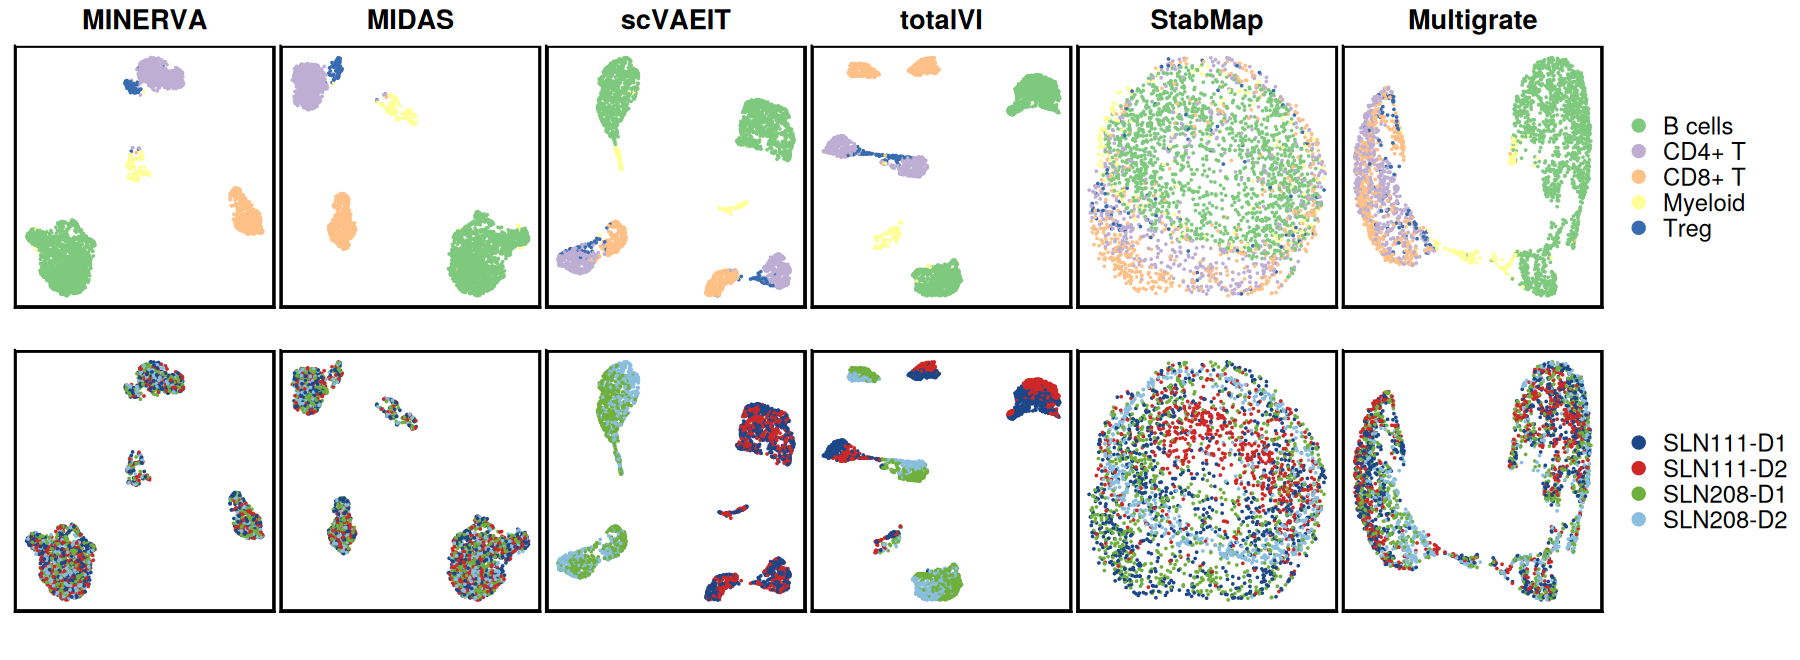

In [7]:
# Q <- q[[1]] / q[[2]] / q[[3]] / q[[4]]
# options(repr.plot.width = 14, repr.plot.height = 20)
Q <- q[[1]]
options(repr.plot.width = 15, repr.plot.height = 5.5)
Q

In [ ]:
ggsave("figure5.png", Q, dpi = 300, width = 50, height = 70, units = "cm")
# ggsave("figure5_0.png", Q, dpi = 300, width = 14, height = 5)